In [ ]:
%pylab inline
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
plt.style.use('seaborn-white') 
pd.set_option('display.max_columns', None)

In [7]:
idx = 100416
exp_name = 'vent_exp0002_k7_p0_s0'
top_exp_dir = '/tigress/BEE/usr/lifangc/workspace/mimic_experiment/' + exp_name + '/'
with open(top_exp_dir + 'config/' + exp_name + '.cfg', 'r') as f:
    lines = f.readlines()
    feature_array = np.int_(lines[17][:-2].split())
    print feature_array, len(feature_array)
f.close()
VITAL_CONFIG_FILE = "/tigress/BEE/usr/lifangc/workspace/vital_config.pkl"
vitals_list, vital_lb_list, vital_ub_list = pickle.load(open(VITAL_CONFIG_FILE, 'rb'))

top_data_dir = '/tigress/BEE/usr/lifangc/workspace/mimic_vent_global_nor/'
global_mean = pickle.load(open(top_data_dir + 'global_mean_array.pkl', 'rb'))
global_std = pickle.load(open(top_data_dir + 'global_std_array.pkl', 'rb'))
print global_mean[feature_array]
print global_std[feature_array]

true_test_time = pickle.load(open(top_data_dir + 'test_data/stage0/common/hadm_{}_test_time.pkl'.format(idx), 'rb'))


[ 0  1  2  3  4  5  6  7  9 10 11 12] 12
[  87.06486135   20.02994668   97.29568353   76.99789441  121.36907286
   63.32276651   48.54697516    6.61507337  491.18267523    7.39126335
  143.95096476   42.22691795]
[  1.79693942e+01   5.80314554e+00   2.82123319e+00   1.52186155e+01
   2.20734437e+01   1.51134074e+01   1.45672284e+01   2.73576765e+00
   1.31415503e+02   7.72722435e-02   8.66821301e+01   9.90798268e+00]


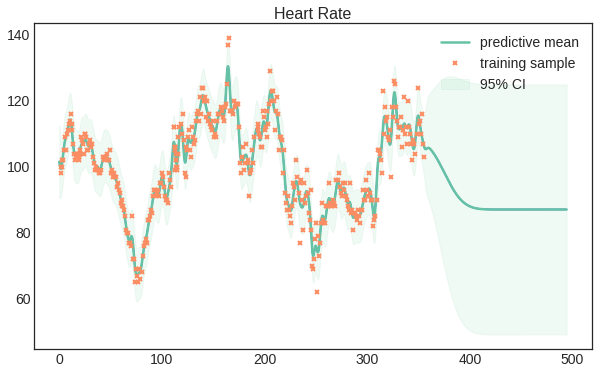

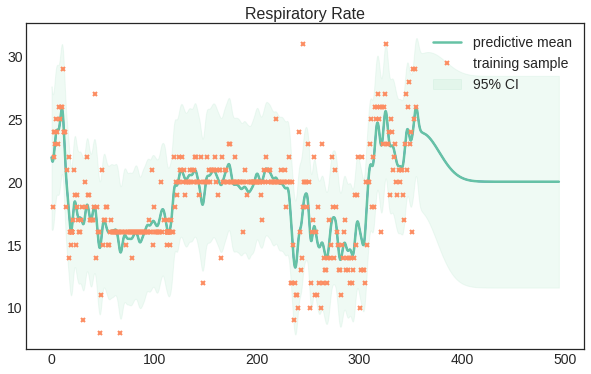

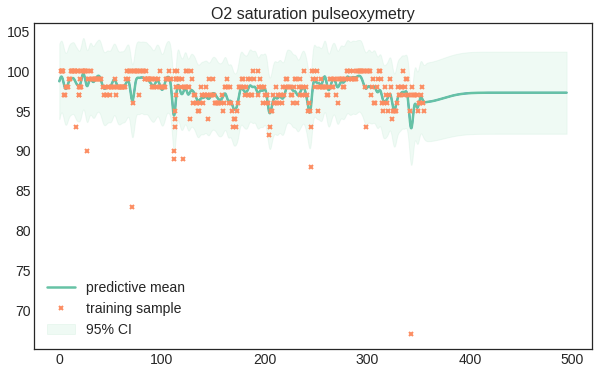

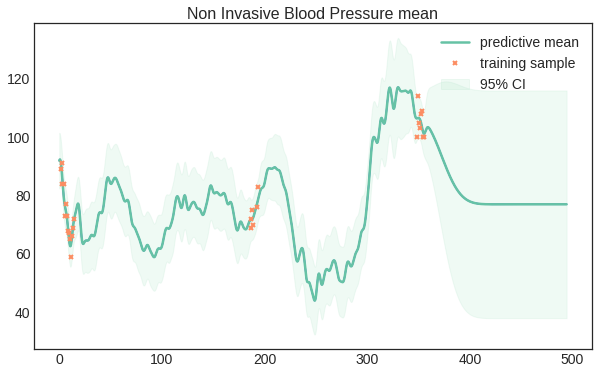

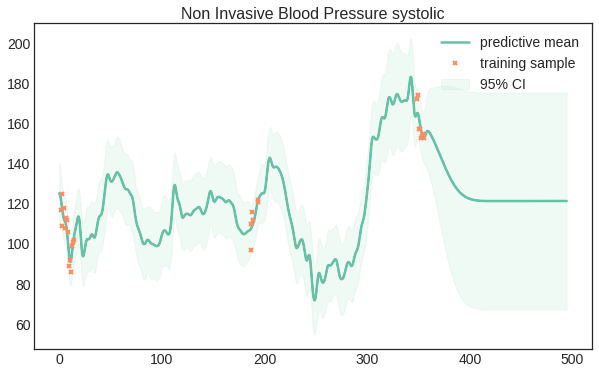

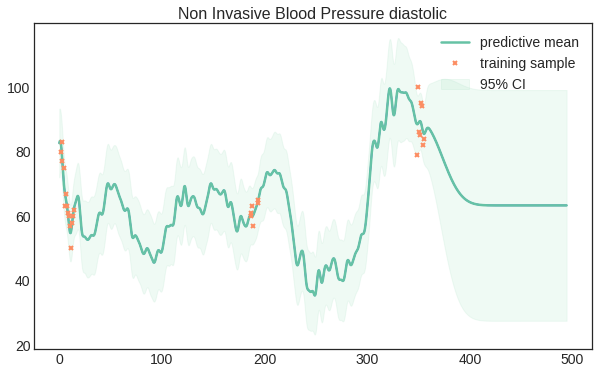

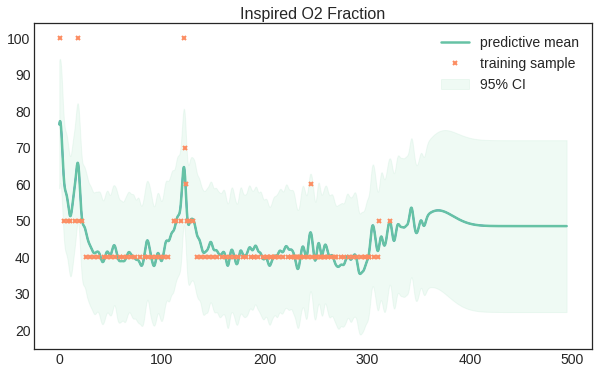

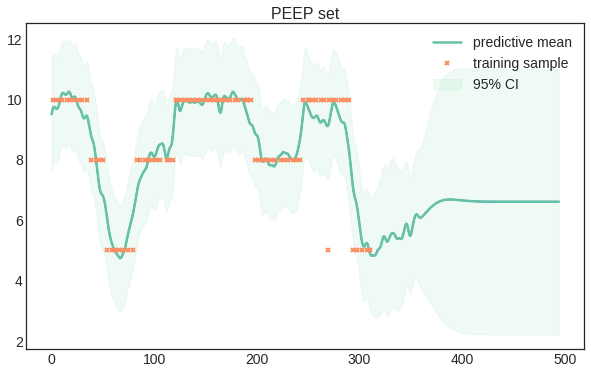

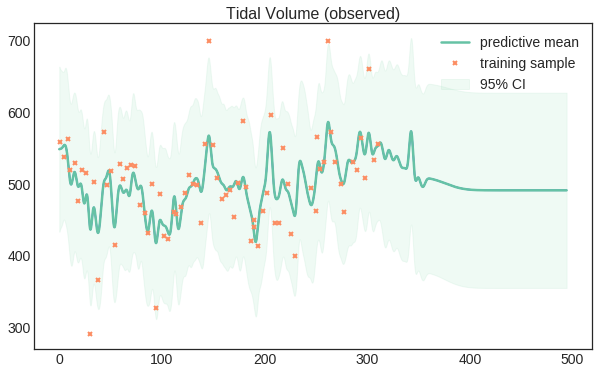

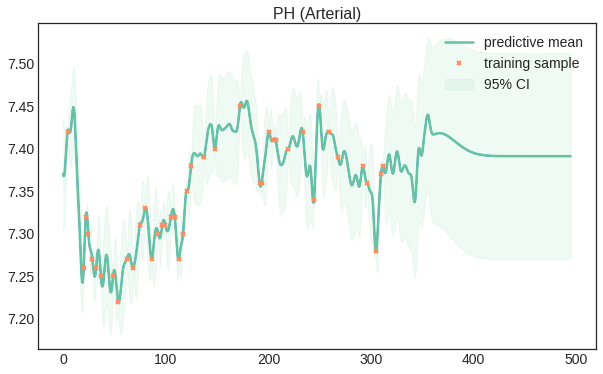

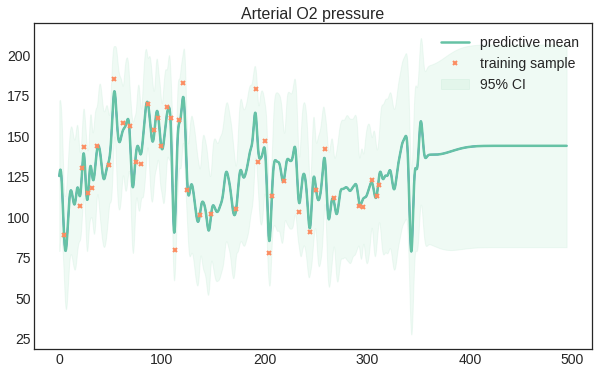

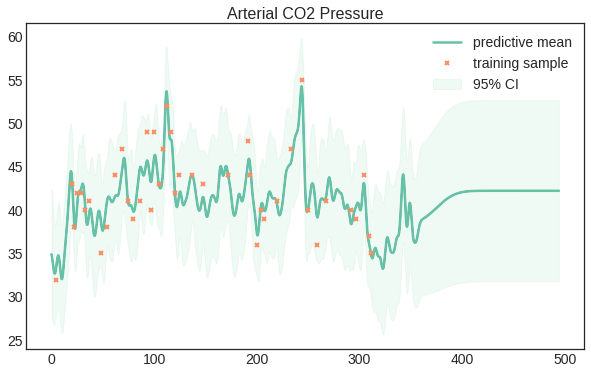

In [23]:
all_df = pd.DataFrame()
plt.style.use('seaborn-white')
palette = [(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 
           (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), 
           (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961)]
for fidx in feature_array:
    # load train data
    train_data_file = top_data_dir + 'train_data/stage0/feature{}/hadm_{}_train_data.txt'.format(fidx, idx)
    f = open(train_data_file, 'r')
    lines = f.readlines()
    f.close()
    train_time = np.float_(lines[1::2])
    train_value = np.float_(lines[2::2])
    
    # load test data
    test_time_file = top_data_dir + 'test_data/stage0/common/hadm_{}_test_time.txt'.format(idx)
    f = open(test_time_file, 'r')
    lines = f.readlines()
    f.close()
    test_time = np.float_(lines[1:])

    test_data_file = top_exp_dir + 'test/hadm_{}/none/gmm/self_smooth_feature{}_test_data.csv'.format(idx, fidx)
    df = pd.read_csv(test_data_file, header=None)
    
    assert len(test_time) == df.shape[0]
    assert len(test_time) == len(true_test_time)
    test_value = df[df.columns[0]].values
    test_var = df[df.columns[1]].values
    lower = test_value - 1.96*np.sqrt(test_var)
    upper = test_value + 1.96*np.sqrt(test_var)
    
    # plot in original scale
    train_value = train_value*global_std[fidx] + global_mean[fidx]
    test_value = test_value*global_std[fidx] + global_mean[fidx]
    lower = lower*global_std[fidx] + global_mean[fidx]
    upper = upper*global_std[fidx] + global_mean[fidx]
    
    fill_color = "#b3e6cb" #B8DCF7"
    line_color = palette[0]
    marker_color = palette[1]
    plt.figure(figsize=(10, 6))
    plt.plot(test_time, test_value, 'b-')
    plt.fill_between(test_time, lower, upper, color=fill_color, alpha=0.2, label='95% CI')
    plt.plot(test_time, test_value, linewidth=2.5, color=line_color, label='predictive mean')
    plt.plot(train_time, train_value, linestyle='None', color=marker_color, marker='x', markersize=4, markeredgewidth=2, label='training sample')
    plt.title(vitals_list[fidx], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    
    # organize final output as dataframe
    dic ={}
    dic['hadm'] = idx*np.ones(len(test_value),).astype(int_)
    dic['label'] = [vitals_list[fidx] for x in range(len(test_value))]
    dic['charttime'] = true_test_time
    dic['value'] = test_value
    dic['95% ci'] = (upper - lower)/2
    sub_df = pd.DataFrame(dic)
    
    if(all_df.shape[0] == 0):
        all_df = sub_df
    else:
        all_df = all_df.append(sub_df, ignore_index=True)

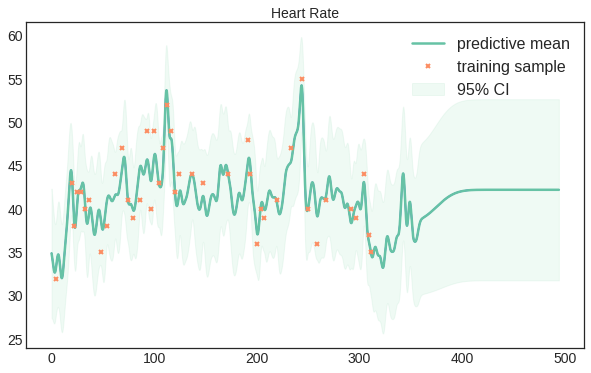

In [21]:
plt.style.use('seaborn-white')
fill_color = "#b3e6cb" #B8DCF7"
line_color = palette[0]
marker_color = palette[1]
plt.figure(figsize=(10, 6))
plt.plot(test_time, test_value, 'b-')
plt.fill_between(test_time, lower, upper, color=fill_color, alpha=0.2, label='95% CI')
plt.plot(test_time, test_value, linewidth=2.5, color=line_color, label='predictive mean')
plt.plot(train_time, train_value, linestyle='None', color=marker_color, marker='x', markersize=4, markeredgewidth=2, label='training sample')
plt.title(vitals_list[0], fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

In [25]:
validIDs = pd.read_pickle("/tigress/BEE/usr/lifangc/workspace/mimic_experiment/vent_exp0002_k7_p0_s0/df/valid_id.pkl")


In [ ]:
sns.choose_colorbrewer_palette()

In [15]:
feature_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12])

In [17]:
vitals_list

['Heart Rate',
 'Respiratory Rate',
 'O2 saturation pulseoxymetry',
 'Non Invasive Blood Pressure mean',
 'Non Invasive Blood Pressure systolic',
 'Non Invasive Blood Pressure diastolic',
 'Inspired O2 Fraction',
 'PEEP set',
 'Ventilator Mode',
 'Tidal Volume (observed)',
 'PH (Arterial)',
 'Arterial O2 pressure',
 'Arterial CO2 Pressure']